In [2]:
# import argparse
import random
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.pyplot import imshow
from matplotlib import cm
import gc
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from PIL import Image
from tqdm import tqdm_notebook as tqdm

from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

iters = [10, 20, 30, 40, 50, 75, 100, 200, 500, 1000, None];

args = {
    "data_dir": "../data"
}


In [4]:
os.listdir("../data/")

['creditcardfraud',
 'creditcardfraud.zip',
 'sample_submission.csv',
 'test.zip',
 'train',
 'train.zip',
 'train_labels.csv']

In [5]:
train_labels = pd.read_csv('../data/train_labels.csv')

collecting
predicted mem usage: 0.8393287658691406 GB
(32, 32)
collecting
collecting
collecting
collecting
collecting
collecting
collecting
collecting
collecting
collecting
collecting



0

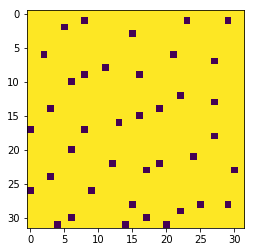

In [6]:
DATA_DIR = '../data/train'
EXTENTION = '.tif'

num_train_labels = len(train_labels)

y = np.empty(num_train_labels)
X = None

for index, row in tqdm(train_labels.iterrows(), total=len(train_labels)):
    if (index % 20000 == 0):
        print("collecting")
        gc.collect();
    
    img_path = os.path.join(DATA_DIR, row["id"] + EXTENTION)
    
    img = Image.open(img_path).convert('1')
    width, height = img.size   # Get dimensions
    left = (width - 32)/2
    top = (height - 32)/2
    right = (width + 32)/2
    bottom = (height + 32)/2
    img = img.crop((left, top, right, bottom))#.resize((16, 16), Image.ANTIALIAS)
    arr = np.array(img).ravel()
    
    
    if X is None: 
        print("predicted mem usage: " + str((len(arr.ravel()) * num_train_labels * 4) /(2**30.0)) + " GB")
        X = np.empty((num_train_labels, len(arr.ravel())))
        imshow(np.asarray(img))
        print(img.size)
        
    y[index] = row["label"]
    X[index] = arr

gc.collect()

In [7]:
preNormalized = X;
X = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=420)
X = None
preNormalized = None
gc.collect()

2302

In [ ]:
clf = DecisionTreeClassifier()
score = cross_val_score(clf, X_train, y_train, cv=10, verbose=5, n_jobs=-1)
print();
print("SCORE FOR UNTOUCHED")
print(score)
print();

In [ ]:
#100
#100

#looking good
data = {}

for depth in iters:
    for leaves in iters:
        clf = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes=leaves)
        score = cross_val_score(clf, X_train, y_train, cv=10, verbose=5, n_jobs=-1)
        print();
        print(score)
        print(depth)
        print(leaves)
        if (leaves not in data) data[leaves] = {};
        data[leaves][depth] = sum(score)/float(len(score))
        print()
        gc.collect()

In [ ]:
print(len(X))

In [ ]:
os.listdir('./')
X_plot = []
Y_plot = []
Z_plot = []
iters = [10, 20, 30, 40, 50, 75, 100, 200];
with open ("gridsearchresults.txt", "r") as myfile:
    rawString = myfile.readlines()
    counter = 5
    
    for depth in iters:
        for leaves in iters:
            X_plot.append(depth)
            Y_plot.append(leaves)
            currentArr = (rawString[counter] + rawString[counter + 1])[1:-2].split(" ")
            parsedArr = [float(x) for x in currentArr if x is not ""]
            Z_plot.append(sum(parsedArr)/float(len(parsedArr)))
            counter += 10

In [40]:
X_plot = np.array(X_plot)
Z_plot = np.array(Z_plot)
Y_plot = np.array(Y_plot)

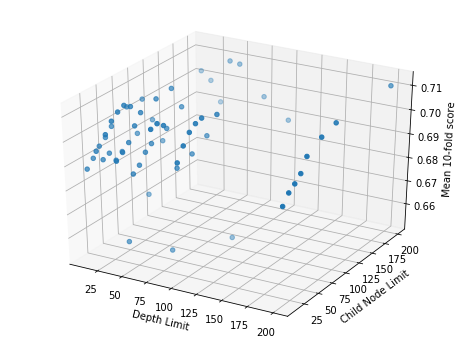

In [44]:
fig = plt.figure(figsize=(8.0, 6.0))
ax = fig.gca(projection='3d')

# Make data.
X = X_plot
Y = Y_plot
# X, Y = np.meshgrid(X_plot, Y_plot)
Z= Z_plot

# Plot the surface.
surf = ax.scatter(X_plot, Y_plot, Z_plot)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Depth Limit")
ax.set_ylabel("Child Node Limit")
ax.set_zlabel("Mean 10-fold score")

plt.savefig("gridSearch.png")
plt.show()

In [ ]:


param_dist = {
              "n_neighbors": sp_randint(2, 100),
              "p": [1, 2]
}
rand_kNN = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_jobs=-1, cv=10, n_iter=100, verbose=2)
rand_kNN.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [6]:
pca = PCA(.4)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
pca_train_img = pca.transform(X_train)

In [8]:
print(len(X_train[0]))
print(len(pca_train_img[0]))
gc.collect()

64
24


0

In [10]:
neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [11]:
neigh.fit(pca_train_img, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')

In [12]:
neigh.score(pca_train_img, y_train)

0.7757370393188635

In [9]:
param_dist = {
              "n_neighbors": sp_randint(2, 50),
              "p": [1, 2]
}
rand_kNN = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_jobs=-1, cv=10, n_iter=5, verbose=2)
rand_kNN.fit(pca_train_img, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 407.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 689.1min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002A365DED5C0>, 'p': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [11]:
rand_kNN.best_score_

0.5964943289129491

In [17]:
rand_kNN.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([1.37242892, 1.2609268 , 1.26491649, 1.27698379, 1.33802078]),
 'std_fit_time': array([0.08586663, 0.11357803, 0.10156049, 0.12459993, 0.12726242]),
 'mean_score_time': array([611.3204705 , 632.51806576, 608.83204553, 632.7060698 ,
        611.6805016 ]),
 'std_score_time': array([ 2.87752526,  1.88039598,  1.53210399,  7.66428852, 58.32035689]),
 'param_n_neighbors': masked_array(data=[12, 34, 9, 10, 48],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_p': masked_array(data=[2, 1, 2, 1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 12, 'p': 2},
  {'n_neighbors': 34, 'p': 1},
  {'n_neighbors': 9, 'p': 2},
  {'n_neighbors': 10, 'p': 1},
  {'n_neighbors': 48, 'p': 1}],
 'split0_test_score': array([0.59788921, 0.59718225, 0.58869868, 0.5960208 , 0.59793971]),
 'split1_test_score': array([0.59278897, 0.5922

In [18]:
kNN_last_score = cross_val_score(KNeighborsClassifier(n_neighbors=3, p=2), pca_train_img, y_train, cv=10, n_jobs=-1)

In [21]:
kNN_last_score.mean()

0.5784004227918418

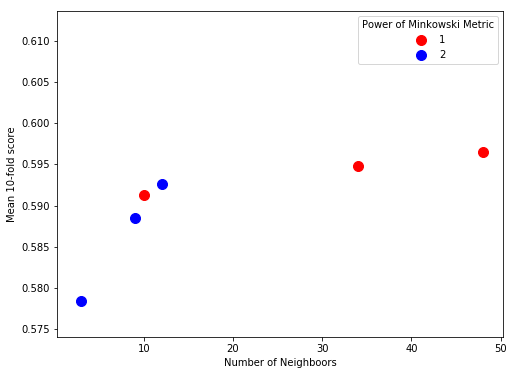

In [39]:
# from mpl_toolkits.mplot3d import Axes3D
xs = [];
ys = [];
zs = [];
for i in range(0, len(rand_kNN.cv_results_['params'])):
    xs.append(rand_kNN.cv_results_['params'][i]['n_neighbors'])
    ys.append(rand_kNN.cv_results_['params'][i]['p'])
    zs.append(rand_kNN.cv_results_['mean_test_score'][i])


xs.append(3)
ys.append(2)
zs.append(0.5784004227918418)

# print(xs, ys, zs)
    
# fig = plt.figure(figsize=(8, 6))

# ax = fig.add_subplot(111)

# ax.scatter(xs, zs, label=ys)


# # ax.set_zlabel('Mean 10-fold score')

# plt.savefig("gridSearchCredit")

scatter_x = np.array(xs)
scatter_y = np.array(zs)
group = np.array(ys)
cdict = {1: 'red', 2: 'blue'}

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
ax.set_xlabel('Number of Neighboors')
ax.set_ylabel('Mean 10-fold score')
ax.legend(title="Power of Minkowski Metric")
plt.show()



In [6]:
best_dtc = DecisionTreeClassifier(max_depth=200, max_leaf_nodes=76)
adaboost = AdaBoostClassifier(base_estimator = best_dtc, n_estimators=100)

In [7]:
adaboost_score = cross_val_score(adaboost, X_train, y_train, cv=10, verbose=10, n_jobs=-1)
print('adaboost Cross Validation Score', round(adaboost_score.mean() * 100, 2).astype(str) + '%')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 280.2min remaining: 653.7min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 283.4min remaining: 283.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 284.1min remaining: 121.8min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 430.8min finished


adaboost Cross Validation Score 68.96%


In [13]:
best_dtc2 = DecisionTreeClassifier(max_depth=200, max_leaf_nodes=200)
adaboost2 = AdaBoostClassifier(base_estimator = best_dtc2, n_estimators=10)

In [10]:
adaboost_score2 = cross_val_score(adaboost2, X_train, y_train, cv=10, verbose=10, n_jobs=-1)
print('adaboost Cross Validation Score', round(adaboost_score2.mean() * 100, 2).astype(str) + '%')

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=200,
            max_features=None, max_leaf_nodes=76,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [16]:
random.randint(1, 1000)

545

In [17]:
using_10_estimators = [.6931273039438469, 0.6941568607646078, 0.6939352623339898, 0.6995101257512247, 0.7040347422107761, 0.6887340301974448, 0.6955006817148917, 0.6918648689592486, 0.7022372607444068, 0.700621180748447]

In [19]:
sum(using_10_estimators)/float(len(using_10_estimators))

0.6963722317368883

In [24]:
ys = [sum(using_10_estimators)/float(len(using_10_estimators))]
ys.append(adaboost_score.mean())

In [25]:
xs = [10, 100]

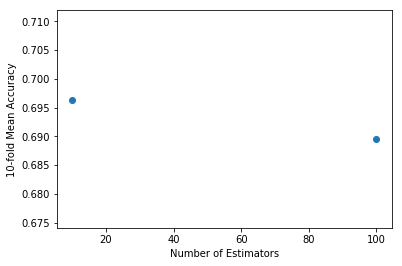

In [26]:
plt.xlabel("Number of Estimators")
plt.ylabel("10-fold Mean Accuracy")
plt.scatter(xs, ys) #382 max

In [ ]:
param_dist = {
              "kernel": ["linear", "rbf", "sigmoid"],
              "C": [50, 100],
}

svm = GridSearchCV(SVC(), param_dist, cv=10, n_jobs=6, verbose=100)
svm.fit(X_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

In [ ]:
rand_kNN.cv_results_